In [1]:
# Standard library imports
import argparse
import gzip
import math
import re
import sys
import urllib.request
import io
import random
from copy import deepcopy

# Third-party library imports
import numpy as np
import pandas as pd
import gensim
import gensim.downloader as api
from gensim import corpora, matutils
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import wordnet
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt
import nltk

# 1. Implementation of the retrofitting algorithm on a toy corpus

### 1.1 Generating a toy corpus of the same format as the real corpora

In [2]:
# load pre-trained Word2Vec model to generate the toy corpus
model = api.load('word2vec-google-news-300')

In [3]:
# Creating functions to generate a toy corpus in the same format as for the provided word embeddings
def convert_matrix_to_dict(wordVecMat, wordList):
    wordVecs = {}
    for i, word in enumerate(wordList):
        wordVecs[word] = wordVecMat[i]
    return wordVecs

def convert_dict_to_matrix(wordVecs):
    wordVecMat = np.stack(list(wordVecs.values()))
    return wordVecMat

def vectorize_list(corpus):
    corpus_vecs = [model[word] for word in corpus]
    return corpus_vecs

# Useful for the big corpus to retrive the word list from the keys
def get_embeddings_words(wordVecs):
    wordList = list(wordVecs.keys()) 
    return wordList

In [4]:
# Get the same input format as the real corpus, i.e a dictionnary having for keys the words and for values their corresponding embeddings
toy_corpus = ["cat", "tiger", "computer", "keyboard", "plane", "car", "doctor", "nurse", "love", "sex"]
toy_list_vecs = vectorize_list(toy_corpus)
toy_wordVecs = convert_matrix_to_dict(toy_list_vecs, toy_corpus)
toy_wordList = get_embeddings_words(toy_wordVecs) # Not necessary for the toy corpus as toy_wordList == toy_corpus but generated here for reproductibility reasons with the real corpus

 ### 1.2 Calculating the similarities between the words of the corpus before the retrofitting

In [5]:
def calculate_cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_product = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    similarity = dot_product / norm_product
    return similarity

def generate_cosine_similarity_matrix(dict_vecs): 
    num_vectors = len(dict_vecs)
    similarity_matrix = np.zeros((num_vectors, num_vectors))
    for i, word1 in enumerate(dict_vecs):
        for j, word2 in enumerate(dict_vecs):
            similarity_matrix[i, j] = calculate_cosine_similarity(dict_vecs[word1], dict_vecs[word2])
    return similarity_matrix

def print_vec_similarities(wordList, similarity_matrix):
    for word, vec in zip(wordList, similarity_matrix):
        print(f'Similarities with "{word}":')
        for i in range(len(vec)):
            similarity = vec[i]
            print(f'  - "{wordList[i]}": {similarity:.4f}')
        print()

def print_vec_difference(wordList, similarity_matrix1, similarity_matrix2):
    for i, word in enumerate(wordList):
        print(f"\nSimilarities with \"{word}\":")
        for j, neighbor in enumerate(wordList):
            similarity1 = similarity_matrix1[i, j]
            similarity2 = similarity_matrix2[i, j]
            difference = similarity2 - similarity1 
            print(f"  - \"{neighbor}\": {similarity1:.4f} -> {similarity2:.4f} (Update: {difference:.4f})")

In [6]:
# Generate a matrix of similarity between the word vectors of the corpus
toy_similarity_matrix = generate_cosine_similarity_matrix(toy_wordVecs)
# Check its shape and dimension
print(type(toy_similarity_matrix)) 
print(toy_similarity_matrix.shape)  
print(toy_similarity_matrix.ndim) 
print('')
print_vec_similarities(toy_wordList, toy_similarity_matrix)

<class 'numpy.ndarray'>
(10, 10)
2

Similarities with "cat":
  - "cat": 1.0000
  - "tiger": 0.5173
  - "computer": 0.1732
  - "keyboard": 0.1834
  - "plane": 0.1833
  - "car": 0.2153
  - "doctor": 0.1292
  - "nurse": 0.1594
  - "love": 0.1406
  - "sex": 0.1368

Similarities with "tiger":
  - "cat": 0.5173
  - "tiger": 1.0000
  - "computer": 0.0677
  - "keyboard": 0.0654
  - "plane": 0.1660
  - "car": 0.1672
  - "doctor": 0.0835
  - "nurse": 0.1111
  - "love": 0.0871
  - "sex": 0.2222

Similarities with "computer":
  - "cat": 0.1732
  - "tiger": 0.0677
  - "computer": 1.0000
  - "keyboard": 0.3964
  - "plane": 0.1909
  - "car": 0.2461
  - "doctor": 0.1628
  - "nurse": 0.2178
  - "love": 0.0573
  - "sex": 0.1853

Similarities with "keyboard":
  - "cat": 0.1834
  - "tiger": 0.0654
  - "computer": 0.3964
  - "keyboard": 1.0000
  - "plane": 0.1006
  - "car": 0.1498
  - "doctor": 0.0850
  - "nurse": 0.1220
  - "love": 0.1591
  - "sex": 0.0943

Similarities with "plane":
  - "cat": 0.1833
  -

### 1.3 Managing the words' neighbors

In [7]:
def get_wordnet_lexicon(target_words, relation_types):
    lexicon = {}
        
    for word in target_words:
        related_words = []
        word_synsets = wordnet.synsets(word)
        
        # Skip word if no synsets found
        if not word_synsets:
            continue

        for syn in word_synsets:
            for lemma in syn.lemmas():
                if lemma.name() != word:
                    if "synonyms" in relation_types:
                        related_words.append(lemma.name())
                    if "antonyms" in relation_types:
                        if syn.lemmas()[0].antonyms():
                            related_words.append(syn.lemmas()[0].antonyms()[0].name())
                    if "hyponyms" in relation_types:
                        for hypo in syn.hyponyms():
                            for lemma in hypo.lemmas():
                                related_words.append(lemma.name())
                    if "hypernyms" in relation_types:
                        for hyper in syn.hypernyms():
                            for lemma in hyper.lemmas():
                                related_words.append(lemma.name())
                    if "meronyms" in relation_types:
                        for part in syn.part_meronyms():
                            for lemma in part.lemmas():
                                related_words.append(lemma.name())
                    if "holonyms" in relation_types:
                        for whole in syn.part_holonyms():
                            for lemma in whole.lemmas():
                                related_words.append(lemma.name())
                    if "homonyms" in relation_types:
                        for lemma in syn.lemmas():
                            if lemma.name() != word:
                                homonyms = wordnet.lemmas(lemma.name())
                                for homonym in homonyms:
                                    related_words.append(homonym.name())
        lexicon[word] = related_words
    return lexicon

In [8]:
# Generate a matrix of embeddings from the values in the word vectors dictionary
toy_wordVecMat = convert_dict_to_matrix(toy_wordVecs)

# Checking its shape and dimension 
print(type(toy_wordVecMat)) 
print(toy_wordVecMat.shape)  
print(toy_wordVecMat.ndim) 

<class 'numpy.ndarray'>
(10, 300)
2


In [9]:
def create_neighbors_embedding_matrix(wordList, relation_type):
    # Retrieve synonyms for each word
    neighbors_dict = get_wordnet_lexicon(wordList, relation_type)
    
    # Compute average embedding
    average_embeddings = []
    for word in wordList:
        neighbors = neighbors_dict.get(word, [])
        embeddings = [
            model.get_vector(neighbor)
            for neighbor in neighbors
            if model.has_index_for(neighbor)
        ]
        if len(embeddings) > 0:
            average_embedding = np.sum(embeddings, axis=0) / len(embeddings)
        else:
            # Handle the case where a word has no embeddings for its synonyms
            average_embedding = np.zeros(model.vector_size) 
        average_embeddings.append(average_embedding)
    
    # Create the word embedding matrix
    neighbors_embedding_matrix = np.vstack(average_embeddings)
    return neighbors_embedding_matrix

In [10]:
# Generate the neighbor matrix for the words in the toy corpus
toy_neighbors_matrix = create_neighbors_embedding_matrix(toy_wordList, "synonyms")
# Check its shape and dimension (they should match those of the matrix of embeddings)
print(type(toy_neighbors_matrix)) 
print(toy_neighbors_matrix.shape) 
print(toy_neighbors_matrix.ndim) 

<class 'numpy.ndarray'>
(10, 300)
2


### 1.4 Retrofitting

In [11]:
def retrofitting_wordVecs(wordVecMat, neighbors_matrix, alpha, beta, nb_iter):
    # Create a deep copy of wordVecMat 
    newWordVecMat = np.copy(wordVecMat, order='K')
    
    for _ in range(nb_iter):        
        # Update the word embeddings using retrofitting formula
        newWordVecMat = (alpha * newWordVecMat + beta * neighbors_matrix) / (alpha + beta)

        # TODO: calculer similarité après chaque itération
        # Stoping criterion
        if np.linalg.norm(newWordVecMat - wordVecMat) < 1e-2:
            break # TODO: return the embedding

    return newWordVecMat

In [12]:
# Retrofitting the toy word embeddings
toy_retrofitted_vecs = retrofitting_wordVecs(toy_wordVecMat, toy_neighbors_matrix, alpha=1, beta=1, nb_iter=10)
# Convert the matrix of retrofitted embeddings to a dictionary
toy_retrofitted_wordVecs = convert_matrix_to_dict(toy_retrofitted_vecs, toy_wordList)
# Generate the similarity matrix
toy_retrofitted_similarity_matrix = generate_cosine_similarity_matrix(toy_retrofitted_wordVecs)
print_vec_difference(toy_wordList, toy_similarity_matrix, toy_retrofitted_similarity_matrix)


Similarities with "cat":
  - "cat": 1.0000 -> 1.0000 (Update: 0.0000)
  - "tiger": 0.5173 -> 0.2028 (Update: -0.3145)
  - "computer": 0.1732 -> 0.1974 (Update: 0.0241)
  - "keyboard": 0.1834 -> 0.2057 (Update: 0.0223)
  - "plane": 0.1833 -> 0.3947 (Update: 0.2114)
  - "car": 0.2153 -> 0.2636 (Update: 0.0483)
  - "doctor": 0.1292 -> 0.3436 (Update: 0.2144)
  - "nurse": 0.1594 -> 0.5487 (Update: 0.3893)
  - "love": 0.1406 -> 0.5941 (Update: 0.4535)
  - "sex": 0.1368 -> 0.2601 (Update: 0.1233)

Similarities with "tiger":
  - "cat": 0.5173 -> 0.2028 (Update: -0.3145)
  - "tiger": 1.0000 -> 1.0000 (Update: 0.0000)
  - "computer": 0.0677 -> 0.0903 (Update: 0.0226)
  - "keyboard": 0.0654 -> 0.1831 (Update: 0.1177)
  - "plane": 0.1660 -> 0.0734 (Update: -0.0926)
  - "car": 0.1672 -> 0.1005 (Update: -0.0668)
  - "doctor": 0.0835 -> 0.0891 (Update: 0.0056)
  - "nurse": 0.1111 -> 0.2028 (Update: 0.0917)
  - "love": 0.0871 -> 0.1912 (Update: 0.1041)
  - "sex": 0.2222 -> 0.1883 (Update: -0.0339)



In [13]:
def measure_embedding_updates(original_matrix, retrofitted_matrix):
    absolute_diff = np.abs(original_matrix - retrofitted_matrix)
    mean_absolute_diff = np.mean(absolute_diff)
    return mean_absolute_diff

### 1.5 Tuning the (hyper)parameters

In [37]:
# Tuning the (hyper)parameters
def tune_params_test(wordVecMat, neighbors_matrix, val_start, val_end, interval, min_nb_iter, max_nb_iter):
    best_embed_update = 0  # Variable to store the best similarity score
    best_params = {}  # Dictionary to store the best hyperparameter values
    iteration_count = 0

    for alpha in np.arange(val_start, val_end, interval):
        for beta in np.arange(val_start, val_end, interval):
            for nb_iter in range(min_nb_iter, max_nb_iter):
                # Retrofit the embeddings
                retrofitted_vec = retrofitting_wordVecs(wordVecMat, neighbors_matrix, alpha, beta, nb_iter)
                embed_update = measure_embedding_updates(wordVecMat, retrofitted_vec)
                # print(" alpha =", alpha, " beta=", beta, "nb_iter =", nb_iter, " similarity score =", similarity_score)
                if embed_update > best_embed_update:
                    best_embed_update = embed_update
                    best_params = {'alpha': alpha, 'beta': beta, 'nb_iter': nb_iter}
                
                iteration_count += 1
                if iteration_count >= 100:
                    break
            if iteration_count >= 100:
                break
        if iteration_count >= 100:
            break

    print("Best hyperparameters:", best_params)
    print("Best embedding update:", best_embed_update)
    return alpha, beta, nb_iter

In [43]:
def tune_params(wordVecMat, neighbors_matrix, val_start, val_end, interval, min_nb_iter, max_nb_iter):
    best_embed_update = 0
    best_params = {}
    iteration_count = 0

    alpha_values = np.arange(val_start, val_end, interval)
    beta_values = np.arange(val_start, val_end, interval)
    nb_iter_values = range(min_nb_iter, max_nb_iter)

    performance_scores = np.zeros((len(alpha_values), len(beta_values), len(nb_iter_values)))

    for alpha_index, alpha in enumerate(alpha_values):
        for beta_index, beta in enumerate(beta_values):
            for nb_iter_index, nb_iter in enumerate(nb_iter_values):
                retrofitted_vec = retrofitting_wordVecs(wordVecMat, neighbors_matrix, alpha, beta, nb_iter)
                embed_update = measure_embedding_updates(wordVecMat, retrofitted_vec)
                performance_scores[alpha_index, beta_index, nb_iter_index] = embed_update

                if embed_update > best_embed_update:
                    best_embed_update = embed_update
                    best_params = {'alpha': alpha, 'beta': beta, 'nb_iter': nb_iter}

                iteration_count += 1
                if iteration_count >= 100:
                    break
            if iteration_count >= 100:
                break
        if iteration_count >= 100:
            break

    print("Best hyperparameters:", best_params)
    print("Best embedding update:", best_embed_update)

    return performance_scores, alpha_values, beta_values, nb_iter_values, best_params["alpha"], best_params["beta"], best_params["nb_iter"]

In [44]:
toy_perf, toy_a_values, toy_b_vales, toy_it_values, toy_alpha, toy_beta, toy_nb_iter = tune_params(toy_wordVecMat, toy_neighbors_matrix, val_start=0.1, val_end=3.1, interval=0.5, min_nb_iter=1, max_nb_iter=16)

Best hyperparameters: {'alpha': 0.1, 'beta': 1.1, 'nb_iter': 15}
Best embedding update: 0.12671235242449622


In [45]:
# Retrofitting the original embeddings with the new (hyper)parameter values
toy_new_retrofitted_vec = retrofitting_wordVecs(toy_wordVecMat, toy_neighbors_matrix, toy_alpha, toy_beta, toy_nb_iter)
toy_new_retrofitted_dict = convert_matrix_to_dict(toy_new_retrofitted_vec, toy_wordList)
toy_new_retrofitted_similarity_matrix = generate_cosine_similarity_matrix(toy_new_retrofitted_dict)
print_vec_difference(toy_wordList, toy_similarity_matrix, toy_new_retrofitted_similarity_matrix)


Similarities with "cat":
  - "cat": 1.0000 -> 1.0000 (Update: 0.0000)
  - "tiger": 0.5173 -> 0.2020 (Update: -0.3153)
  - "computer": 0.1732 -> 0.1972 (Update: 0.0239)
  - "keyboard": 0.1834 -> 0.2055 (Update: 0.0220)
  - "plane": 0.1833 -> 0.3945 (Update: 0.2111)
  - "car": 0.2153 -> 0.2635 (Update: 0.0482)
  - "doctor": 0.1292 -> 0.3434 (Update: 0.2141)
  - "nurse": 0.1594 -> 0.5485 (Update: 0.3892)
  - "love": 0.1406 -> 0.5941 (Update: 0.4535)
  - "sex": 0.1368 -> 0.2599 (Update: 0.1231)

Similarities with "tiger":
  - "cat": 0.5173 -> 0.2020 (Update: -0.3153)
  - "tiger": 1.0000 -> 1.0000 (Update: 0.0000)
  - "computer": 0.0677 -> 0.0903 (Update: 0.0226)
  - "keyboard": 0.0654 -> 0.1831 (Update: 0.1177)
  - "plane": 0.1660 -> 0.0731 (Update: -0.0930)
  - "car": 0.1672 -> 0.1003 (Update: -0.0669)
  - "doctor": 0.0835 -> 0.0891 (Update: 0.0056)
  - "nurse": 0.1111 -> 0.2026 (Update: 0.0915)
  - "love": 0.0871 -> 0.1910 (Update: 0.1040)
  - "sex": 0.2222 -> 0.1881 (Update: -0.0341)



In [18]:
# Checking the difference between the first retrofitted similarity matrix and the one with the updated (hyper)parameter values
print_vec_difference(toy_wordList, toy_retrofitted_similarity_matrix, toy_new_retrofitted_similarity_matrix)


Similarities with "cat":
  - "cat": 1.0000 -> 1.0000 (Update: -0.0000)
  - "tiger": 0.2028 -> 0.2020 (Update: -0.0008)
  - "computer": 0.1974 -> 0.1972 (Update: -0.0002)
  - "keyboard": 0.2057 -> 0.2055 (Update: -0.0003)
  - "plane": 0.3947 -> 0.3945 (Update: -0.0002)
  - "car": 0.2636 -> 0.2635 (Update: -0.0001)
  - "doctor": 0.3436 -> 0.3434 (Update: -0.0002)
  - "nurse": 0.5487 -> 0.5485 (Update: -0.0001)
  - "love": 0.5941 -> 0.5941 (Update: -0.0001)
  - "sex": 0.2601 -> 0.2599 (Update: -0.0002)

Similarities with "tiger":
  - "cat": 0.2028 -> 0.2020 (Update: -0.0008)
  - "tiger": 1.0000 -> 1.0000 (Update: -0.0000)
  - "computer": 0.0903 -> 0.0903 (Update: 0.0000)
  - "keyboard": 0.1831 -> 0.1831 (Update: 0.0001)
  - "plane": 0.0734 -> 0.0731 (Update: -0.0004)
  - "car": 0.1005 -> 0.1003 (Update: -0.0001)
  - "doctor": 0.0891 -> 0.0891 (Update: -0.0000)
  - "nurse": 0.2028 -> 0.2026 (Update: -0.0002)
  - "love": 0.1912 -> 0.1910 (Update: -0.0002)
  - "sex": 0.1883 -> 0.1881 (Updat

# 2. Retrofitting the English gensim corpus

### 2.1 Retrieving the word vectors from the gensim file and the lexicon from the ws353 file

In [19]:
isNumber = re.compile(r'\d+.*')

def norm_word(word):
  """
  - input: word
  - return: a normalized version of it
  Normalization process: includes checking if the word is a number or a punctuation mark and replacing it with special tokens
  """
  if isNumber.search(word.lower()):
    return '---num---'
  # check if the word consists only of non-alphanumeric characters by removing all non-alphanumeric characters from the word 
  # and checking if the result is an empty string
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
  # if input word not a number nor a punctuation mark, return a lowercase version of input word
    return word.lower()
  
''' Read all the word vectors and normalize them '''
def read_word_vecs(filename):
  """
  - input: name of the file containing the word vectors
  """
  wordVectors = {}
  with open(filename, 'r', encoding='utf-8') as fileObject:
    first_line = True
    for line in fileObject:
      line = line.strip().lower()
      # Skip the first line
      if first_line:
        first_line =False
        continue
      # The first word is assumed to be the word itself, and the remaining words are assumed to be the components of the word vector
      word = line.split()[0]
      # initialize a numpy array of zeros with the same length as the word vector
      wordVectors[word] = np.zeros(len(line.split())-1, dtype=float)
      for index, vecVal in enumerate(line.split()[1:]):
        # assign the values in the numpy array to the corresponding components of the word vector
        wordVectors[word][index] = float(vecVal)
      ''' normalize weight vector '''
      # divide each element by the square root of the sum of the squares of all the elements in the array
      # plus a small constant (1e-6) to avoid division by zero
      wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
  
  # standard error indicating that the vectors have been read from the file 
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

''' Read the PPDB word relations as a dictionary '''
def read_lexicon(filename):
    lexicon = {}
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            words = line.lower().strip().split()
            lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]

''' Write word vectors to file '''
def print_word_vecs(wordVectors, outFileName):
  """
  - input: a dictionary wordVectors where keys are words and values are their corresponding word vectors
           file name outFileName
  """
  sys.stderr.write('\nWriting down the vectors in '+outFileName+'\n')
  outFile = open(outFileName, 'w', encoding= 'utf-8')  
  for word, values in wordVectors.items():
    outFile.write(word+' ')
    for val in wordVectors[word]:
      # write the word vectors to the ouptut file in the format:
      # word1 val1 val2 val3 ...
      # word2 val1 val2 val3 ...
      # ...
      outFile.write('%.4f' %(val)+' ')
    outFile.write('\n')      
  outFile.close()

In [20]:
# Retrieving the word vectors in a dictionary (key: word, value: embedding)
EN_wordVecs = read_word_vecs("../data/English/wordEmbeddings/vectors_datatxt_250_sg_w10_i5_c500_gensim_clean")
# Retrieving the pairs of words with human scores
EN_lexical_similarity = read_lexicon("../data/English/lexicon/ws353_lexical_similarity.txt")
# Creating an output file to print back the updated embeddings
EN_output_file = "../data/English/output_vectors/output_vectors.txt"

Vectors read from: ../data/English/wordEmbeddings/vectors_datatxt_250_sg_w10_i5_c500_gensim_clean 


In [21]:
# Retrieving the necessary objects for the retrofitting
EN_wordList = get_embeddings_words(EN_wordVecs)
EN_neighbors_dict = get_wordnet_lexicon(EN_wordList, "synonyms") #["antonyms", "hyponyms", "hypernyms", "meronyms", "holonyms", "homonyms"]
EN_wordVecMat = convert_dict_to_matrix(EN_wordVecs)

### 2.2 Calculating the similarities before retrofitting the embeddings

In [22]:
# Check the similarity between the word vectors of the corpus 
# (only considering the words in the lexicon similarity file)

def print_lexical_similarities(wordVecs, lines, lang):
    # Create a list to store the words
    word_list = []

    # Iterate over the lines and extract the words
    for line in lines:
        if lang == 'en':
            words = line.strip().split('\t')
        else:
            words = line.strip().split()
        word1 = words[0]
        word2 = words[1]
        word_list.append((word1, word2))  # Store the words as a tuple

    # Determine the subset of words present in the wordVecs file while preserving the order
    subset = [word for word in word_list if word[0] in wordVecs and word[1] in wordVecs]

    # Create a dictionary to map words to indices
    w2i = {word: index for index, word in enumerate(wordVecs)}

    # Create an empty list to store the similarities
    similarities = []

    # Iterate over each tuple in the subset
    for word1, word2 in subset:
        if word1 in wordVecs and word2 in wordVecs:
            # Retrieve the embeddings for the words
            embedding1 = wordVecs[word1]
            embedding2 = wordVecs[word2]

            # Calculate the similarity between the embeddings
            similarity_score = cosine_similarity([embedding1], [embedding2])

            # Append the similarity value to the list of similarities
            similarities.append(similarity_score)

    # Print the similarities
    for i, similarity_score in enumerate(similarities):
        print(f"Similarity between '{subset[i][0]}' and '{subset[i][1]}': {similarity_score[0][0]}")

def print_similarity_difference(wordVecs1, wordVecs2, lines, lang):
    # Create a list to store the words
    word_list = []

    # Iterate over the lines and extract the words
    for line in lines:
        if lang == 'en':
            words = line.strip().split('\t')
        else:
            words = line.strip().split()
        word1 = words[0]
        word2 = words[1]
        word_list.append((word1, word2))  # Store the words as a tuple

    # Determine the subset of words present in both wordVecs1 and wordVecs2 while preserving the order
    subset = [word for word in word_list if word[0] in wordVecs1 and word[1] in wordVecs2]

    # Create an empty list to store the similarity scores
    similarities1 = []
    similarities2 = []

    # Iterate over each tuple in the subset
    for word1, word2 in subset:
        # Retrieve the embeddings for the words from wordVecs1
        embedding1 = wordVecs1[word1]
        embedding2 = wordVecs1[word2]

        # Calculate the similarity between the embeddings in wordVecs1
        similarity_score1 = cosine_similarity([embedding1], [embedding2])

        # Retrieve the embeddings for the words from wordVecs2
        embedding1 = wordVecs2[word1]
        embedding2 = wordVecs2[word2]

        # Calculate the similarity between the embeddings in wordVecs2
        similarity_score2 = cosine_similarity([embedding1], [embedding2])

        # Append the similarity scores to the respective lists
        similarities1.append(similarity_score1[0][0])
        similarities2.append(similarity_score2[0][0])

    # Print the similarities and their difference
    for i, (word1, word2) in enumerate(subset):
        similarity1 = similarities1[i]
        similarity2 = similarities2[i]
        difference = similarity1 - similarity2
        test=[]
        if difference != 0.0:        
            print(f"Similarity between '{word1}' and '{word2}' before retrofitting: {similarity1}")
            print(f"Similarity between '{word1}' and '{word2}' after retrofitting: {similarity2}")
            print(f"Update: {difference}\n")

In [23]:
# Retrive word pairs from the lexical similarity file
with open('../data/English/lexicon/ws353_lexical_similarity.txt', 'r') as file:
    EN_lines = file.readlines()
# Get their similarities
print_lexical_similarities(EN_wordVecs, EN_lines, "en")

Similarity between 'love' and 'sex': 0.3213976283166737
Similarity between 'tiger' and 'cat': 0.4484269447717373
Similarity between 'tiger' and 'tiger': 1.0
Similarity between 'book' and 'paper': 0.5720403096134581
Similarity between 'computer' and 'keyboard': 0.4902811841797181
Similarity between 'computer' and 'internet': 0.49881600720718505
Similarity between 'plane' and 'car': 0.4094837589536879
Similarity between 'train' and 'car': 0.5024532628135742
Similarity between 'telephone' and 'communication': 0.36768667290283835
Similarity between 'television' and 'radio': 0.6536351915117727
Similarity between 'media' and 'radio': 0.3209847572779895
Similarity between 'drug' and 'abuse': 0.42865908078081993
Similarity between 'bread' and 'butter': 0.8071053286387004
Similarity between 'cucumber' and 'potato': 0.6915610413305441
Similarity between 'doctor' and 'nurse': 0.5676552249319599
Similarity between 'professor' and 'doctor': 0.5076438957646101
Similarity between 'student' and 'profe

### 2.3 Generating a matrix of neighbors' embeddings

In [24]:
# Generating the matrix of neighbor's embeddings has been updated to retrieve the embeddings from the matrix of embeddings to update rather than from word2vec
def retrieve_neighbors_embedding_matrix(wordVecMat, wordList, neighbors_dict):
    valid_neighbors = set(neighbor for neighbors in neighbors_dict.values() for neighbor in neighbors) & set(wordList)

    embedding_size = wordVecMat.shape[1]
    average_embeddings = []

    for word in wordList:
        neighbors = neighbors_dict.get(word, [])
        if neighbors and any(neighbor in valid_neighbors for neighbor in neighbors):
            embeddings = np.array([
                wordVecMat[wordList.index(neighbor)] if neighbor in wordList else np.zeros(embedding_size)
                for neighbor in neighbors
                if neighbor in valid_neighbors
            ])
            if embeddings.size > 0:
                average_embedding = np.mean(embeddings, axis=0)
                average_embeddings.append(average_embedding)
        else:
            average_embeddings.append(np.zeros(embedding_size))

    neighbors_embedding_matrix = np.vstack(average_embeddings)
    return neighbors_embedding_matrix

In [25]:
# Generate the matrix of neighbor's embeddings
EN_neighbors_matrix= retrieve_neighbors_embedding_matrix(EN_wordVecMat, EN_wordList, EN_neighbors_dict)

In [26]:
# Visualizing the matrix of neighbor's embedding on a subset
EN_subset_wordVecs = {word: EN_wordVecs[word] for word in EN_wordList[:100]}
EN_subset_neighbors_dict = {word: EN_neighbors_dict[word] for word in list(EN_neighbors_dict.keys())[:100]}
EN_subset_wordVecMat = EN_wordVecMat[:100] 
EN_subset_wordList = EN_wordList[:100]

# Test the function on the subset
EN_subset_neighbors_matrix = retrieve_neighbors_embedding_matrix(EN_subset_wordVecMat, EN_subset_wordList, EN_subset_neighbors_dict)

# Print the result
print(EN_subset_neighbors_matrix)
print(type(EN_subset_neighbors_matrix))  
print(EN_subset_neighbors_matrix.shape)  
print(EN_subset_neighbors_matrix.ndim) 

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.07520224 0.07037208 0.0224631  ... 0.03620975 0.02141031 0.15191107]
 [0.         0.         0.         ... 0.         0.         0.        ]]
<class 'numpy.ndarray'>
(100, 250)
2


### 2.4 Retrofitting 

In [27]:
# Checking that the matrices we pass as argument of the retrofitting algorithm have the same shape and dimension
print("Matrix of word embeddings")
print(type(EN_neighbors_matrix))  
print(EN_neighbors_matrix.shape)  
print(EN_neighbors_matrix.ndim) 
print("\nMatrix of neighbors' embeddings")
print(type(EN_wordVecMat))  
print(EN_wordVecMat.shape)  
print(EN_wordVecMat.ndim) 

Matrix of word embeddings
<class 'numpy.ndarray'>
(125776, 250)
2

Matrix of neighbors' embeddings
<class 'numpy.ndarray'>
(125776, 250)
2


In [28]:
# Retrofitting the English word embeddings
EN_retrofitted_vecs = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix, alpha=1, beta=1, nb_iter=10)

In [29]:
# Calculate the similarities between word embedding pairs after the retrofitting
EN_retrofitted_wordVecs = convert_matrix_to_dict(EN_retrofitted_vecs, EN_wordList)
print_similarity_difference(EN_wordVecs, EN_retrofitted_wordVecs, EN_lines, "en")

Similarity between 'love' and 'sex' before retrofitting: 0.3213976283166737
Similarity between 'love' and 'sex' after retrofitting: 0.47673179076915473
Update: -0.15533416245248105

Similarity between 'tiger' and 'cat' before retrofitting: 0.4484269447717373
Similarity between 'tiger' and 'cat' after retrofitting: 0.37263892654144615
Update: 0.07578801823029113

Similarity between 'book' and 'paper' before retrofitting: 0.5720403096134581
Similarity between 'book' and 'paper' after retrofitting: 0.6017146691372111
Update: -0.02967435952375297

Similarity between 'computer' and 'keyboard' before retrofitting: 0.4902811841797181
Similarity between 'computer' and 'keyboard' after retrofitting: 0.34049956739588355
Update: 0.14978161678383456

Similarity between 'computer' and 'internet' before retrofitting: 0.49881600720718505
Similarity between 'computer' and 'internet' after retrofitting: 0.27021129120136117
Update: 0.22860471600582388

Similarity between 'plane' and 'car' before retrofi

### 2.5 Tuning the (hyper)parameters

In [49]:
# Tuning the (hyper)parameters
EN_perf, EN_a_values, EN_b_values, EN_it_values, EN_alpha, EN_beta, EN_nb_iter = tune_params(EN_wordVecMat, EN_neighbors_matrix, val_start=0.1, val_end=3.1, interval=1, min_nb_iter=1, max_nb_iter=6)

Best hyperparameters: {'alpha': 0.1, 'beta': 2.1, 'nb_iter': 5}
Best embedding update: 0.048375377899576244


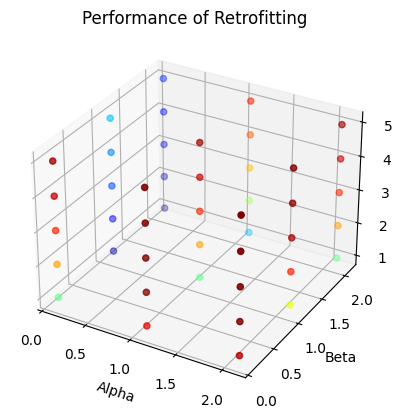

In [51]:
# Create a meshgrid for the hyperparameter values
EN_alpha_mesh, EN_beta_mesh, EN_nb_iter_mesh = np.meshgrid(EN_a_values, EN_b_values, EN_it_values)

# Plot the performances
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(EN_alpha_mesh, EN_beta_mesh, EN_nb_iter_mesh, c=EN_perf.flatten(), cmap='jet')
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Number of Iterations')
ax.set_title('Performance of Retrofitting')
plt.show()

In [53]:
# Retrofitting the original embeddings with the new (hyper)parameter values
EN_new_retrofitted_vec = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix, EN_alpha, EN_beta, EN_nb_iter)
EN_new_retrofitted_dict = convert_matrix_to_dict(EN_new_retrofitted_vec, EN_wordList)
print_similarity_difference(EN_wordVecs, EN_new_retrofitted_dict, EN_lines, "en")

Similarity between 'love' and 'sex' before retrofitting: 0.3213976283166737
Similarity between 'love' and 'sex' after retrofitting: 0.47643997518879716
Update: -0.15504234687212348

Similarity between 'tiger' and 'cat' before retrofitting: 0.4484269447717373
Similarity between 'tiger' and 'cat' after retrofitting: 0.3721418119120698
Update: 0.07628513285966748

Similarity between 'book' and 'paper' before retrofitting: 0.5720403096134581
Similarity between 'book' and 'paper' after retrofitting: 0.6010852121085877
Update: -0.029044902495129588

Similarity between 'computer' and 'keyboard' before retrofitting: 0.4902811841797181
Similarity between 'computer' and 'keyboard' after retrofitting: 0.3401041354897838
Update: 0.1501770486899343

Similarity between 'computer' and 'internet' before retrofitting: 0.49881600720718505
Similarity between 'computer' and 'internet' after retrofitting: 0.26977087270454997
Update: 0.22904513450263508

Similarity between 'plane' and 'car' before retrofitt

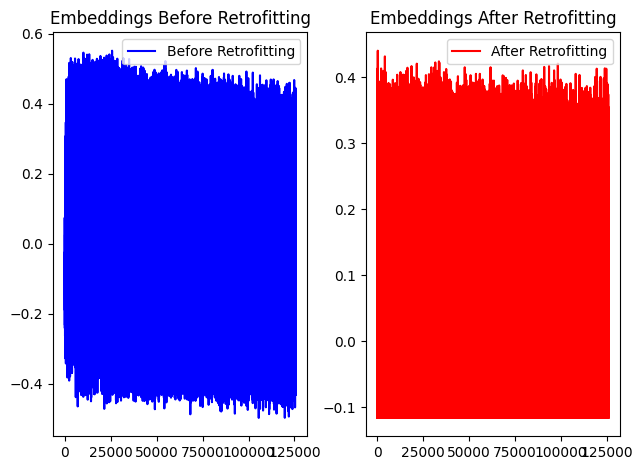

In [55]:
# TODO: plot performances

from sklearn.decomposition import PCA

def visualize_embedding_improvement(embeddings_before, embeddings_after):
    # Perform PCA on the embeddings before retrofitting
    pca_before = PCA(n_components=1)
    embeddings_before_pca = pca_before.fit_transform(embeddings_before)

    # Perform PCA on the embeddings after retrofitting
    pca_after = PCA(n_components=1)
    embeddings_after_pca = pca_after.fit_transform(embeddings_after)

    # Create x-axis values for the curves
    x = np.arange(len(embeddings_before_pca))

    # Plot the embeddings before retrofitting as a curve
    plt.subplot(1, 2, 1)
    plt.plot(x, embeddings_before_pca, 'b-', label='Before Retrofitting')
    plt.title('Embeddings Before Retrofitting')
    plt.legend()

    # Plot the embeddings after retrofitting as a curve
    plt.subplot(1, 2, 2)
    plt.plot(x, embeddings_after_pca, 'r-', label='After Retrofitting')
    plt.title('Embeddings After Retrofitting')
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_embedding_improvement(EN_wordVecMat, EN_retrofitted_vecs)

### 2.6 Testing the performances depending on the type of semantic relation

In [ ]:
def calculate_cosine_similarity_batch(X, Y, batch_size):
    n_samples_X = X.shape[0]
    n_samples_Y = Y.shape[0]
    cos_similarities = np.zeros((n_samples_X, n_samples_Y))

    for i in range(0, n_samples_X, batch_size):
        batch_X = X[i:i+batch_size]
        cos_similarities[i:i+batch_size] = cosine_similarity(batch_X, Y)

    return cos_similarities

In [ ]:
# Check the best semantic relation types for the retrofitting
relation_types = ["antonyms", "hyponyms", "hypernyms", "meronyms", "holonyms", "homonyms"]
EN_avg_cos_similarities = []
for relation_type in relation_types:
    # Retrieve the neighbors for EN_wordList using the current relation_type
    EN_neighbors_dict_rt = get_wordnet_lexicon(EN_wordList, relation_type)

    # Generate the matrix of neighbor embeddings using EN_neighbors_dict
    EN_neighbors_matrix_rt = retrieve_neighbors_embedding_matrix(EN_wordVecMat, EN_wordList, EN_neighbors_dict_rt)

    # Perform retrofitting on wordVecMat using neighbors_matrix
    EN_retrofitted_wordVecs_rt = retrofitting_wordVecs(EN_wordVecMat, EN_neighbors_matrix_rt, alpha=1, beta=1, nb_iter=10)

    # Define batch size
    batch_size = 1000

    # Calculate the cosine similarity between the original and retrofitted embeddings in batches
    EN_cos_similarities = calculate_cosine_similarity_batch(EN_wordVecMat, EN_retrofitted_wordVecs_rt, batch_size)

    # Compute the average cosine similarity
    avg_cos_similarity = np.mean(EN_cos_similarities)

plt.plot(relation_types, EN_avg_cos_similarities, marker='o')
plt.xlabel('Relation Types')
plt.ylabel('Average Cosine Similarity')
plt.title('Retrofitting Performance based on Relation Types')
plt.xticks(rotation=45)
plt.show()

MemoryError: Unable to allocate 118. GiB for an array with shape (125776, 125776) and data type float64

In [ ]:
print_word_vecs(EN_retrofitted_wordVecs, EN_output_file)


Writing down the vectors in ../data/English/output_vectors/output_vectors.txt


# 3. Retrofitting the French wiki corpus

In [ ]:
# Retrieving the word vectors in a dictionary (key: word, value: embedding)
FR_wordVecs = read_word_vecs("../data/French/word_embeddings/vecs100-linear-frwiki")
# Retrieving the pairs of words with human scores
FR_lexical_similarity = read_lexicon("../data/French/lexicon/rg65_french.txt")
# Creating an output file to print back the updated embeddings
FR_output_file = "../data/French/output_vectors/output_vectors.txt"

Vectors read from: ../data/French/word_embeddings/vecs100-linear-frwiki 


In [ ]:
# Retrieving the necessary objects for the retrofitting
FR_wordList = get_embeddings_words(FR_wordVecs)
FR_neighbors_dict = get_wordnet_lexicon(FR_wordList, "synonyms") #["antonyms", "hyponyms", "hypernyms", "meronyms", "holonyms", "homonyms"]
FR_wordVecMat = convert_dict_to_matrix(FR_wordVecs)

In [ ]:
# Retrive word pairs from the lexical similarity file
with open('../data/French/lexicon/rg65_french.txt', 'r') as file:
    FR_lines = file.readlines()
# Get their similarities
print_lexical_similarities(FR_wordVecs, FR_lines, "fr")

Similarity between 'corde' and 'sourire': 0.4669326346248422
Similarity between 'midi' and 'ficelle': 0.17987154414903447
Similarity between 'fruit' and 'fournaise': 0.19855455062830601
Similarity between 'autographe' and 'rivage': 0.2359732441183503
Similarity between 'automobile' and 'sorcier': 0.2780385970271853
Similarity between 'monticule' and 'four': 0.37188339759122474
Similarity between 'grimace' and 'instrument': 0.08425105107857007
Similarity between 'refuge' and 'fruit': 0.3546915183782402
Similarity between 'refuge' and 'moine': 0.44047104586365804
Similarity between 'verre' and 'magicien': 0.3524265421212991
Similarity between 'coussin' and 'bijou': 0.19221924567126153
Similarity between 'moine' and 'esclave': 0.27402356388110366
Similarity between 'grimace' and 'gars': 0.29618183124645214
Similarity between 'rivage' and 'bois': 0.5382997780515452
Similarity between 'moine' and 'oracle': 0.3304813322413485
Similarity between 'automobile' and 'coussin': 0.1980486936824828


In [ ]:
# Generate the matrix of neighbor's embeddings
FR_neighbors_matrix= retrieve_neighbors_embedding_matrix(FR_wordVecMat, FR_wordList, FR_neighbors_dict)

In [ ]:
# Visualizing the matrix of neighbor's embedding on a subset
FR_subset_wordVecs = {word: FR_wordVecs[word] for word in FR_wordList[:100]}
FR_subset_neighbors_dict = {word: FR_neighbors_dict[word] for word in list(FR_neighbors_dict.keys())[:100]}
FR_subset_wordVecMat = FR_wordVecMat[:100] 
FR_subset_wordList = FR_wordList[:100]

# Test the function on the subset
FR_subset_neighbors_matrix = retrieve_neighbors_embedding_matrix(FR_subset_wordVecMat, FR_subset_wordList, FR_subset_neighbors_dict)

# Print the result
print(FR_subset_neighbors_matrix)
print(type(FR_subset_neighbors_matrix))  
print(FR_subset_neighbors_matrix.shape)  
print(FR_subset_neighbors_matrix.ndim) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>
(100, 100)
2


In [ ]:
# Checking that the matrices we pass as argument of the retrofitting algorithm have the same shape and dimension
print("Matrix of word embeddings")
print(type(FR_neighbors_matrix))  
print(FR_neighbors_matrix.shape)  
print(FR_neighbors_matrix.ndim) 
print("\nMatrix of neighbors' embeddings")
print(type(FR_wordVecMat))  
print(FR_wordVecMat.shape)  
print(FR_wordVecMat.ndim) 

Matrix of word embeddings
<class 'numpy.ndarray'>
(130391, 100)
2

Matrix of neighbors' embeddings
<class 'numpy.ndarray'>
(130391, 100)
2


In [ ]:
# Retrofitting the French word embeddings
FR_retrofitted_vecs = retrofitting_wordVecs(FR_wordVecMat, FR_neighbors_matrix, alpha=1, beta=1, nb_iter=10)

In [ ]:
# Calculate the similarities between word embedding pairs after the retrofitting
FR_retrofitted_wordVecs = convert_matrix_to_dict(FR_retrofitted_vecs, FR_wordList)
print_similarity_difference(FR_wordVecs, FR_retrofitted_wordVecs, FR_lines, "fr")

Similarity between 'automobile' and 'sorcier' before retrofitting: 0.2780385970271853
Similarity between 'automobile' and 'sorcier' after retrofitting: 0.37085750628655917
Update: -0.09281890925937386

Similarity between 'monticule' and 'four' before retrofitting: 0.37188339759122474
Similarity between 'monticule' and 'four' after retrofitting: 0.31096630934587355
Update: 0.06091708824535119

Similarity between 'grimace' and 'instrument' before retrofitting: 0.08425105107857007
Similarity between 'grimace' and 'instrument' after retrofitting: 0.35567062766184043
Update: -0.27141957658327037

Similarity between 'refuge' and 'fruit' before retrofitting: 0.3546915183782402
Similarity between 'refuge' and 'fruit' after retrofitting: 0.46586483241536847
Update: -0.11117331403712827

Similarity between 'refuge' and 'moine' before retrofitting: 0.44047104586365804
Similarity between 'refuge' and 'moine' after retrofitting: 0.27218706285706573
Update: 0.1682839830065923

Similarity between 'gr

In [ ]:
# TODO: tune hyperparametres

In [ ]:
# TODO: experiment whether there is a difference in performance depending on the type of semantic relation